In [1]:
import fsspec
import xarray as xr
import wandb

import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import sklearn


import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import TQDMProgressBar

import pyqg_explorer.dataset.forcing_dataset as forcing_dataset
import pyqg_explorer.models.base_model as base_model
import pyqg_explorer.util.pbar as pbar

In [2]:
import matplotlib.pyplot as plt
import numpy as np

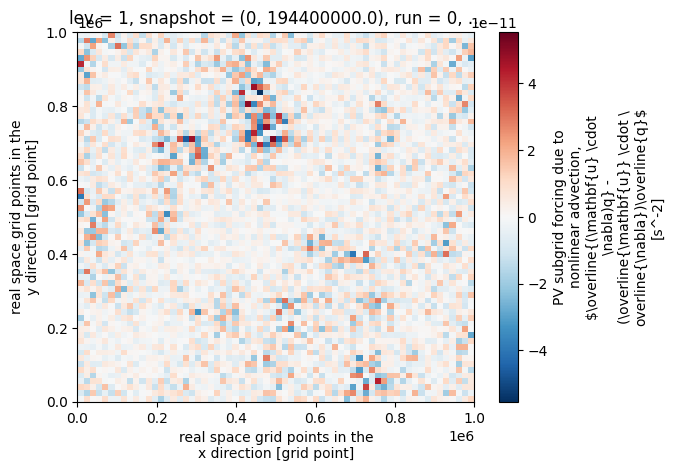

In [3]:
data_full=xr.open_zarr(fsspec.get_mapper(f'/scratch/zanna/data/pyqg/publication/eddy/forcing1.zarr'), consolidated=True)
data_forcing=data_full.q_subgrid_forcing.isel(lev=0)
data_forcing=data_forcing.stack(snapshot=("run","time"))
data_forcing=data_forcing.transpose("snapshot","y","x")
data_forcing.isel(snapshot=54).plot()

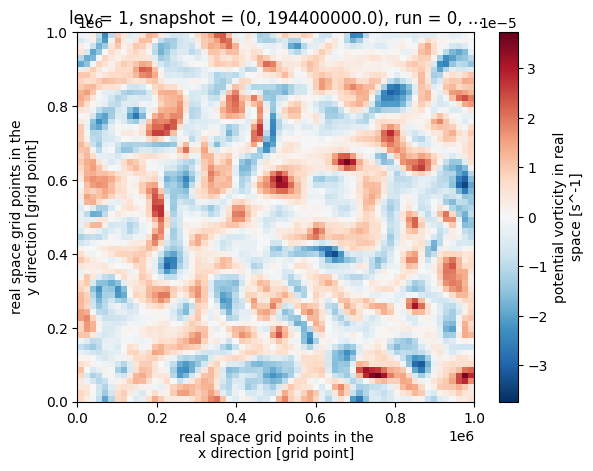

In [4]:
data_q=data_full.q.isel(lev=0)
data_q=data_q.stack(snapshot=("run","time"))
data_q=data_q.transpose("snapshot","y","x")
data_q.isel(snapshot=54).plot()

In [5]:
model_1=base_model.AndrewCNN(1,1)
model_2=base_model.AndrewCNN(1,1)
model_1.load_state_dict(torch.load('/scratch/cp3759/pyqg_data/models/cnn_0.torch'))
model_1.eval()
model_2.load_state_dict(torch.load('/scratch/cp3759/pyqg_data/models/cnn_1.torch'))
model_2.eval()

AndrewCNN(
  (conv): Sequential(
    (0): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=same, padding_mode=circular)
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=same, padding_mode=circular)
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (7): ReLU()
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (10): ReLU()
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
    (13): ReLU()
    (14): BatchNorm2d(32, eps=1e-05, momentum

In [6]:
dataset=forcing_dataset.ForcingDataset(data_q,data_forcing,seed=123)
valid_loader = DataLoader(
    dataset,
    batch_size=64,
    sampler=SubsetRandomSampler(dataset.valid_idx),
)

In [7]:
del dataset
del data_full
del data_q
del data_forcing

In [8]:
x_maps=torch.tensor(())
y_true=torch.tensor(())
y_pred=torch.tensor(())

for valid in valid_loader:
    x=valid[0]
    y=valid[1]
    y_hat=model_1(x)
    ## Concat to form tensors containing all maps
    x_maps=torch.cat((x_maps,x),dim=0)
    y_true=torch.cat((y_true,y),dim=0)
    y_pred=torch.cat((y_pred,y_hat),dim=0)
    
print("done")

done


In [9]:
x_np=x_maps.squeeze().detach().numpy()
y_np=y_true.squeeze().detach().numpy()
y_pred_np=y_pred.squeeze().detach().numpy()

Text(0.5, 1.0, 'True forcing-CNN forcing')

<Figure size 640x480 with 0 Axes>

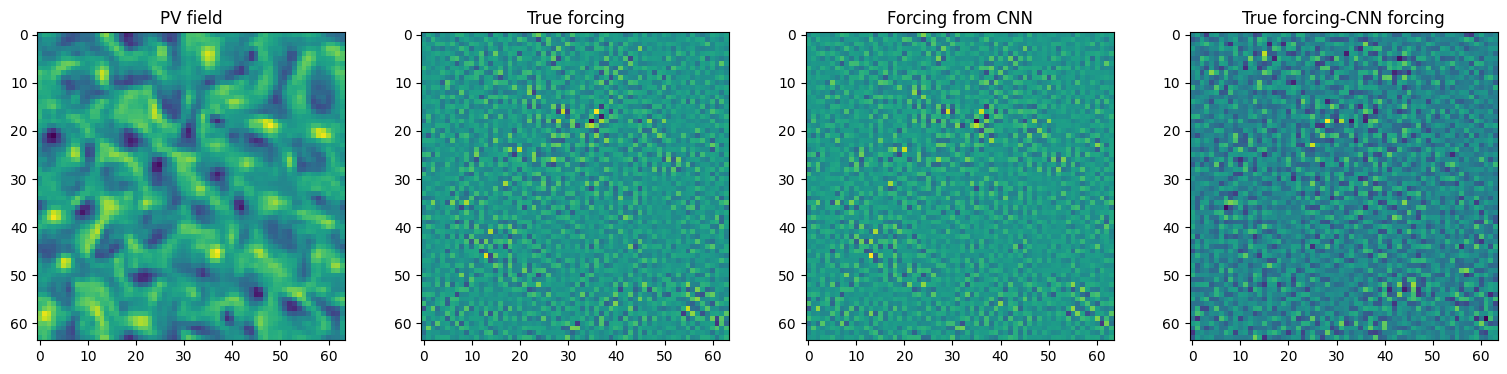

In [10]:
map_index=22
plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,4,figsize=(19,4))
axarr[0].imshow(x_np[map_index])
axarr[1].imshow(y_np[map_index])
axarr[2].imshow(y_pred_np[map_index])
axarr[3].imshow(y_np[map_index]-y_pred_np[map_index])

axarr[0].set_title("PV field")
axarr[1].set_title("True forcing")
axarr[2].set_title("Forcing from CNN")
axarr[3].set_title("True forcing-CNN forcing")

In [11]:
from sklearn.metrics import r2_score
r2_score(y_np.flatten(),y_pred_np.flatten())

0.8779252808610067

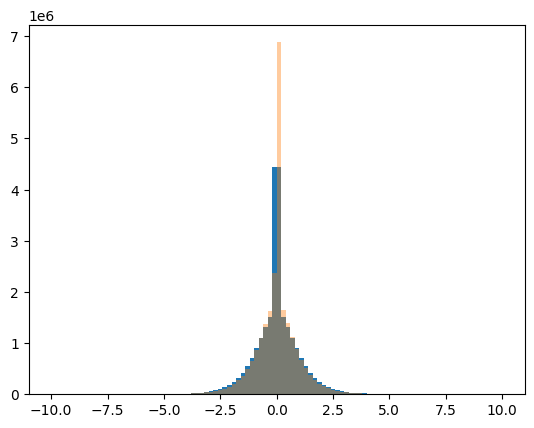

In [12]:
plt.hist(y_np.flatten(),range=[-10,10],bins=100);
plt.hist(y_pred_np.flatten(),range=[-10,10],bins=100,alpha=0.4);